In [1]:
import sys
import pandas as pd
import ast
import pickle
import random
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.utils import from_networkx
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, precision_recall_curve
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')
import utils
import models
import dataset
import train_utils

In [2]:
class AttentionPooling(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, 1)
        )
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, mask=None):
        """
        x: (B, S, D)
        mask: (B, S), 1 if valid, 0 if padded
        """
        z = self.embed(x)  # (B, S, H)
        attn_scores = self.attn(z).squeeze(-1)  # (B, S)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=1)  # (B, S)
        pooled = torch.sum(z * attn_weights.unsqueeze(-1), dim=1)  # (B, H)
        return self.output(pooled)  # (B, output_dim)


In [3]:
class GNNClassifier(nn.Module):
    def __init__(self, 
                 input_dim,        # input dimension of set elements
                 pool_hidden_dim=64,
                 pool_out_dim=128, # dimension of node features after pooling
                 gcn_hidden_dim=128,
                 gcn_out_dim=32,
                 neg_weight=8.0):
        super().__init__()
        self.neg_weight = neg_weight

        # Deep Sets pooling layer
        self.pooling = AttentionPooling(input_dim, pool_hidden_dim, pool_out_dim)

        # GCN layers
        self.conv1 = GCNConv(pool_out_dim, gcn_hidden_dim)
        self.conv2 = GCNConv(gcn_hidden_dim, gcn_out_dim)

        # MLP classifier
        self.mlp = nn.Sequential(
            nn.Linear(gcn_out_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, data, query_node_indices):
        # data.set_features: (num_nodes, set_size, input_dim)
        set_feats = data.set_features  # expected shape: [N, S, D]
        data.x = self.pooling(data.set_features, data.set_mask)

        x = self.conv1(data.x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        x = F.relu(x)

        query_embeddings = x[query_node_indices]
        logits = self.mlp(query_embeddings)
        return logits.squeeze(-1)

    def predict_proba(self, data, query_node_indices):
        with torch.no_grad():
            logits = self.forward(data, query_node_indices)
            return torch.sigmoid(logits)

    def compute_loss(self, logits, labels):
        weights = torch.ones_like(labels, device=labels.device)
        weights[labels == 0] = self.neg_weight
        return F.binary_cross_entropy_with_logits(logits, labels.float(), weight=weights)

In [4]:
class PerturbationDataset(Dataset):
    def __init__(self, label_df, active_nodes_df, node_features_df, node_idx_mapping, device='cpu'):
        self.label_df = label_df.reset_index(drop=True)
        self.device = device
        self.node_idx_mapping = node_idx_mapping  # Mapping from Ensembl ID to node index

        # Build mapping from (Cell Line) to list of active genes (may be useful later)
        self.cell_line_to_active = (
            active_nodes_df.groupby("Cell Line")["Gene"]
            .apply(list)
            .to_dict()
        )

    def __len__(self):
        return len(self.label_df)

    def __getitem__(self, idx):
        row = self.label_df.iloc[idx]
        target_id = row["Target"]
        label = torch.tensor(row["Perturbed"], dtype=torch.float32).to(self.device)

        # Map target Ensembl ID to node index
        try:
            target_idx = self.node_idx_mapping[target_id]
        except KeyError:
            raise ValueError(f"Target node '{target_id}' not found in node_idx_mapping.")

        return target_idx, label

def collate_function(batch):
    target_indices, labels = zip(*batch)
    target_indices = torch.tensor(target_indices, dtype=torch.long)
    labels = torch.stack(labels)
    return target_indices, labels

In [2]:
id_map_df = pd.read_csv('../data/id_mappings/gene_ref.tsv', sep='\t')
id_map_df

,HGNC ID,Approved symbol,Approved name,Status,Previous symbols,Alias symbols,Chromosome,Accession numbers,RefSeq IDs,NCBI Gene ID,Ensembl gene ID,Mouse genome database ID,Pubmed IDs,Alias names
0,HGNC:5,A1BG,alpha-1-B glycoprotein,Approved,NaN,NaN,19q13.43,NaN,NM_130786,1.0,ENSG00000121410,MGI:2152878,2591067,NaN
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,Approved,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569,19q13.43,BC040926,NR_015380,503538.0,ENSG00000268895,NaN,NaN,NaN
2,HGNC:24086,A1CF,APOBEC1 complementation factor,Approved,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF",10q11.23,AF271790,NM_014576,29974.0,ENSG00000148584,MGI:1917115,"11815617, 11072063",NaN
3,HGNC:6,A1S9T,"symbol withdrawn, see [HGNC:12469](/data/gene-...",Symbol Withdrawn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HGNC:7,A2M,alpha-2-macroglobulin,Approved,NaN,"FWP007, S863-7, CPAMD5",12p13.31,"BX647329, X68728, M11313",NM_000014,2.0,ENSG00000175899,MGI:2449119,"2408344, 9697696",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49354,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",Approved,ZYG11,FLJ13456,1p32.3,AB051517,NM_024646,79699.0,ENSG00000162378,MGI:2685277,11214970,NaN
49355,HGNC:13200,ZYX,zyxin,Approved,NaN,NaN,7q34,X95735,NM_003461,7791.0,ENSG00000159840,MGI:103072,"8917469, 8940160",NaN
49356,HGNC:51695,ZYXP1,zyxin pseudogene 1,Approved,NaN,NaN,8q24.23,NaN,NaN,NaN,ENSG00000274572,NaN,NaN,NaN
49357,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,Approved,NaN,"KIAA0399, ZZZ4, FLJ10821",17p13.2,BC035319,NM_015113,23140.0,ENSG00000074755,MGI:2444286,9455477,NaN


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_utils.set_seed(42)

In [4]:
def pad_vector(v, max_len):
    padded = np.zeros(max_len, dtype=np.float32)
    padded[:len(v)] = v
    return padded

def make_padded_set(row, max_len):
    return np.stack([
        pad_vector(row['ESM Embedding'], max_len),
        pad_vector(row['SubCell Embedding'], max_len),
        pad_vector(row['PINNACLE Embedding'], max_len)
    ])  # shape: (3, max_len)


with open('../data/embeddings.pkl', 'rb') as f:
    node_features_df = pickle.load(f)

all_lengths = [
    len(vec)
    for _, row in node_features_df.iterrows()
    for vec in [row['ESM Embedding'], row['SubCell Embedding'], row['PINNACLE Embedding']]
]
max_len = max(all_lengths)

node_features_df['Set Embedding'] = node_features_df.apply(
    lambda row: make_padded_set(row, max_len),
    axis=1
)

train_df = pd.read_csv('../data/perturbation_screens/e_distance/train.csv', index_col=0)

active_nodes_df = pd.read_csv('../data/expression_reference/expression_reference.csv', index_col=0)

G = nx.read_edgelist('../data/networks/global_ppi_edgelist.txt')

ensembl_to_node = dict(zip(id_map_df['Ensembl gene ID'], id_map_df['Approved symbol']))
node_to_ensembl = dict(zip(id_map_df['Approved symbol'], id_map_df['Ensembl gene ID']))

G = nx.relabel_nodes(G, node_to_ensembl)

# Get set of nodes that have features
valid_nodes = set(node_features_df['Ensembl ID'])

# Remove nodes from G that are not in valid_nodes
G.remove_nodes_from([n for n in list(G.nodes) if n not in valid_nodes])

node_to_idx = {node: idx for idx, node in enumerate(G.nodes())}

train_df = train_df[train_df['Target'].isin(G.nodes())]

# Convert to edge_index format
data = from_networkx(G)

set_tensor = torch.stack([
    torch.tensor(node_features_df.set_index('Ensembl ID').loc[idx]['Set Embedding'])
    for idx in G.nodes()
])  # shape: (num_nodes, 3, max_len)

# Mask where entries are non-zero (i.e., not padded)
mask_tensor = (set_tensor != 0).any(dim=-1).to(torch.float32)  # shape: (num_nodes, 3)

data.set_features = set_tensor.to(torch.float32)
data.set_mask = mask_tensor


train_dataset = dataset.GNNDataset(
    train_df.iloc[:int(0.9*len(train_df))],
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

val_dataset = dataset.GNNDataset(
    train_df.iloc[int(0.9*len(train_df)):],
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

input_dim = len(node_features_df['Set Embedding'][0][0])

model = models.GNNAttentionClassifier(
    input_dim=max_len,
    pool_hidden_dim=64,
    pool_out_dim=128,
    gcn_hidden_dim=512,
    gcn_out_dim=128,
    neg_weight=3.0
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=dataset.collate_function_gnn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=dataset.collate_function_gnn)

In [5]:
train_df

,Target,e_distance,p_value,experiment,Cell Line,Perturbed,e_distance_transformed
3290,ENSG00000176407,1.441460,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.368183
2619,ENSG00000168876,0.517026,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,-0.651546
2642,ENSG00000115268,3.966061,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,1.414089
1691,ENSG00000241468,2.367709,0.770000,GasperiniShendure2019_lowMOI_,K562,False,0.876044
728,ENSG00000185085,4.818220,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,1.619822
...,...,...,...,...,...,...,...
85,ENSG00000079805,0.106619,0.544000,TianKampmann2021_CRISPRi_,iPSC-induced neuron,False,-2.146856
3459,ENSG00000135913,5.772353,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,1.812155
1122,ENSG00000168028,2.327481,0.001996,ReplogleWeissman2022_K562_essential_,K562,True,0.858349
3392,ENSG00000102786,2.012167,0.001996,ReplogleWeissman2022_rpe1_,RPE1,True,0.708486


In [6]:
# Training loop for one epoch
def train_one_epoch(model, data, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    y_true, y_pred, y_prob = [], [], []
    class_counts = {0: 0, 1: 0}

    for batch_idx, (query_node_indices, labels) in enumerate(dataloader):
        query_node_indices = query_node_indices.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(data, query_node_indices)
        loss = model.compute_loss(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Predictions & metrics tracking
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)
        y_prob.extend(probs)

        total_loss += loss.item()

        # Track class distribution
        for label in labels.cpu().numpy():
            class_counts[int(label)] += 1

        if (batch_idx + 1) % 10 == 0:
            print(f"[Batch {batch_idx+1}] Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    metrics = train_utils.compute_metrics(np.array(y_true), np.array(y_pred), np.array(y_prob))
    metrics['loss'] = avg_loss

    print(f"\n[Training] Loss: {avg_loss:.4f} | Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['auc']:.4f}")
    print(f"Class distribution: 0 -> {class_counts[0]}, 1 -> {class_counts[1]}")

    return metrics

# Evaluation loop (no gradients)
def evaluate(model, data, dataloader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    class_counts = {0: 0, 1: 0}

    with torch.no_grad():
        for query_node_indices, labels in dataloader:
            query_node_indices = query_node_indices.to(device)
            labels = labels.to(device)

            logits = model(data, query_node_indices)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)
            y_prob.extend(probs)

            for label in labels.cpu().numpy():
                class_counts[int(label)] += 1

    metrics = train_utils.compute_metrics(np.array(y_true), np.array(y_pred), np.array(y_prob))

    print(f"\n[Evaluation] Precision: {metrics['precision']:.4f} | Recall: {metrics['recall']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['auc']:.4f}")
    print(f"Class distribution: 0 -> {class_counts[0]}, 1 -> {class_counts[1]}")

    return metrics, y_true, y_pred, y_prob

# Training loop across multiple epochs
num_epochs = 10
best_val_auc = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")
    train_metrics = train_utils.train_one_epoch_gnn(model, data, train_loader, optimizer, device)
    val_metrics, y_true_val, y_pred_val, y_prob_val = train_utils.evaluate_gnn(model, data, val_loader, device)
    print([int(x) for x in y_true_val])
    print([int(x) for x in y_pred_val])

    # Save model if improved
    if val_metrics['auc'] > best_val_auc:
        best_val_auc = val_metrics['auc']
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"New best model saved with AUC: {best_val_auc:.4f}")



===== Epoch 1/10 =====
[Batch 10] Loss: 1.0393
[Batch 20] Loss: 1.2106
[Batch 30] Loss: 1.0377
[Batch 40] Loss: 0.8695
[Batch 50] Loss: 0.8727
[Batch 60] Loss: 0.8641
[Batch 70] Loss: 1.2092
[Batch 80] Loss: 1.0337
[Batch 90] Loss: 1.2287
[Batch 100] Loss: 1.2147
[Batch 110] Loss: 1.2109
[Batch 120] Loss: 0.8611
[Batch 130] Loss: 0.8356
[Batch 140] Loss: 0.6226
[Batch 150] Loss: 1.0251
[Batch 160] Loss: 1.9201
[Batch 170] Loss: 1.5432
[Batch 180] Loss: 0.8032
[Batch 190] Loss: 1.2910
[Batch 200] Loss: 1.0590
[Batch 210] Loss: 0.8758
[Batch 220] Loss: 1.0236
[Batch 230] Loss: 0.6087
[Batch 240] Loss: 1.0409
[Batch 250] Loss: 1.0757
[Batch 260] Loss: 1.4322
[Batch 270] Loss: 1.2620
[Batch 280] Loss: 1.0099
[Batch 290] Loss: 1.0337
[Batch 300] Loss: 1.2621
[Batch 310] Loss: 0.5946
[Batch 320] Loss: 1.0364
[Batch 330] Loss: 0.8581
[Batch 340] Loss: 0.8561
[Batch 350] Loss: 1.0537

[Training] Loss: 1.0157 | Precision: 0.7689 | Recall: 0.8549 | F1: 0.8096 | AUC: 0.5294
Class distribution: 0

In [16]:
model = train_utils.load_model(
    GNNClassifier,
    input_dim=max_len,
    pool_hidden_dim=64,
    pool_out_dim=128,
    gcn_hidden_dim=512,
    gcn_out_dim=128,
    neg_weight=3.0, 
    path="best_model.pt")

In [17]:
test_df = pd.read_csv('../data/perturbation_screens/e_distance/test.csv')

test_dataset = PerturbationDataset(
    test_df,
    active_nodes_df,
    node_features_df,
    node_to_idx,
    device=device
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_function)

In [18]:
test_metrics, y_true, y_pred, y_prob = evaluate(model, data, test_loader, device)
print(test_metrics)


[Evaluation] Precision: 0.8630 | Recall: 0.7302 | F1: 0.7911 | AUC: 0.7056
Class distribution: 0 -> 166, 1 -> 630
{'precision': np.float64(0.8630393996247655), 'recall': np.float64(0.7301587301587301), 'f1': np.float64(0.7910576096302665), 'auc': np.float64(0.7055651176133104)}


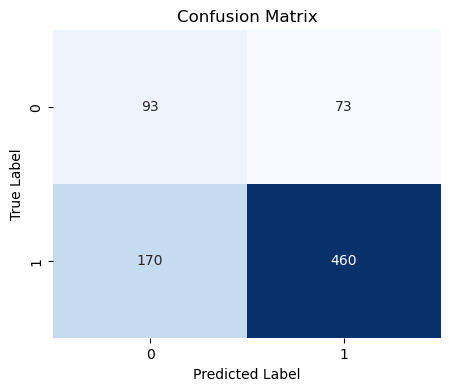

In [19]:
train_utils.plot_confusion_matrix(y_true, y_pred)

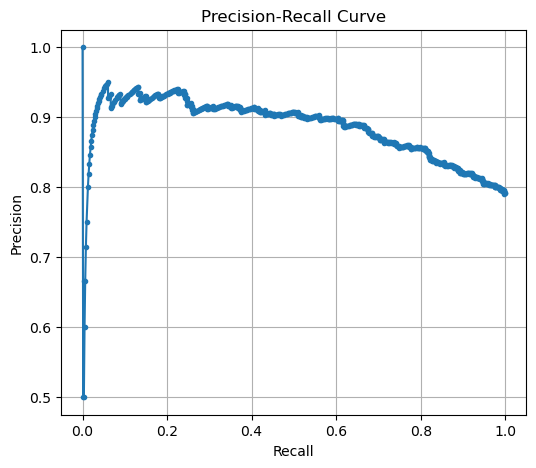

In [20]:
train_utils.plot_precision_recall(y_true, y_prob)

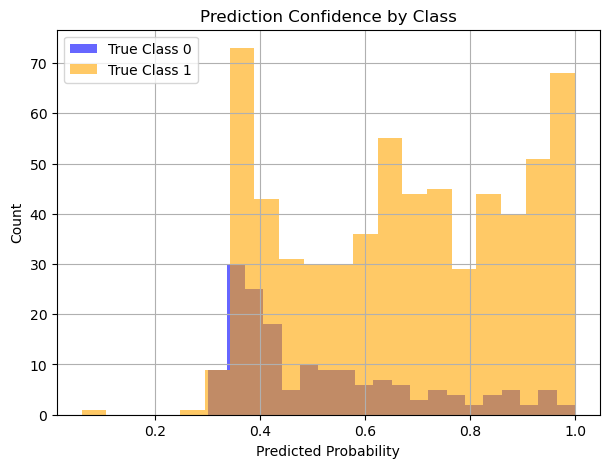

In [21]:
train_utils.plot_prediction_histograms(y_true, y_prob)